In [1]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import plotly.express as px
from plotly.subplots import make_subplots
import missingno as msno
import plotly.figure_factory as ff
import plotly.graph_objects as go
from scipy.stats import gaussian_kde, boxcox
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')

### dataframe

In [2]:
df = pd.read_csv(data_path / 'historical_data copy.csv')

In [3]:
df

market_id           created_at actual_delivery_time  store_id  \
0             1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1             2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2             3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3             3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4             3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   
...           ...                  ...                  ...       ...   
197423        1.0  2015-02-17 00:19:41  2015-02-17 01:24:48      2956   
197424        1.0  2015-02-13 00:01:59  2015-02-13 00:58:22      2956   
197425        1.0  2015-01-24 04:46:08  2015-01-24 05:36:16      2956   
197426        1.0  2015-02-01 18:18:15  2015-02-01 19:23:22      3630   
197427        1.0  2015-02-08 19:24:33  2015-02-08 20:01:41      3630   

       store_primary_category  order_protocol  total_items  subtotal  \
0                    american             1.0            4      3441   
1                     mexican             2.0            1      1900   
2                         NaN             1.0            1      1900   
3                         NaN             1.0            6      6900   
4                         NaN             1.0            3      3900   
...                       ...             ...          ...       ...   
197423                   fast             4.0            3      1389   
197424                   fast             4.0            6      3010   
197425                   fast             4.0            5      1836   
197426               sandwich             1.0            1      1175   
197427               sandwich             1.0            4      2605   

        num_distinct_items  min_item_price  max_item_price  \
0                        4             557            1239   
1                        1            1400            1400   
2                        1            1900            1900   
3                        5             600            1800   
4                        3            1100            1600   
...                    ...             ...             ...   
197423                   3             345             649   
197424                   4             405             825   
197425                   3             300             399   
197426                   1             535             535   
197427                   4             425             750   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                        33.0                14.0                      21.0   
1                         1.0                 2.0                       2.0   
2                         1.0                 0.0                       0.0   
3                         1.0                 1.0                       2.0   
4                         6.0                 6.0                       9.0   
...                       ...                 ...                       ...   
197423                   17.0                17.0                      23.0   
197424                   12.0                11.0                      14.0   
197425                   39.0                41.0                      40.0   
197426                    7.0                 7.0                      12.0   
197427                   20.0                20.0                      23.0   

        estimated_order_place_duration  \
0                                  446   
1                                  446   
2                                  446   
3                                  446   
4                                  446   
...                                ...   
197423                             251   
197424                             251   
197425                             251   
197426                             446   
197427                             446   

        estimated_store_to_consumer_driving_duration  
0           

In [39]:
original_df = pd.read_csv(data_path / 'historical_data copy.csv')

### initial data processing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

#### handeling nulls

In [5]:
msno.matrix(df)

<Axes: >

In [6]:
def nulls_data(df): 

    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    percent_null = (null_counts/len(df)) * 100
    null_table = pd.DataFrame({'column': null_counts.index, 'data type': df[null_counts.index].dtypes, 'number of nulls': null_counts.values, 
                               'precent null': percent_null.values})
    null_table = null_table.sort_values(by='precent null', ascending=False).reset_index(drop=True)

    return null_table

In [7]:
nulls_data(df)

column data type  number of nulls  \
0                         total_onshift_dashers   float64            16262   
1                            total_busy_dashers   float64            16262   
2                      total_outstanding_orders   float64            16262   
3                        store_primary_category    object             4760   
4                                order_protocol   float64              995   
5                                     market_id   float64              987   
6  estimated_store_to_consumer_driving_duration   float64              526   
7                          actual_delivery_time    object                7   

   precent null  
0      8.236927  
1      8.236927  
2      8.236927  
3      2.411006  
4      0.503981  
5      0.499929  
6      0.266426  
7      0.003546

In [8]:
# checking if the null values in these columns occurr all on the same rows
df.loc[df['total_onshift_dashers'].isnull() & df['total_busy_dashers'].isnull() & df['total_outstanding_orders'].isnull()]

market_id           created_at actual_delivery_time  store_id  \
160           6.0  2015-02-06 01:11:56  2015-02-06 01:42:51       976   
161           6.0  2015-02-14 02:07:47  2015-02-14 03:17:37       976   
162           6.0  2015-01-31 21:58:30  2015-01-31 22:55:32       976   
163           6.0  2015-02-08 03:28:59  2015-02-08 05:32:11       976   
164           6.0  2015-01-23 19:29:17  2015-01-23 20:25:25       976   
...           ...                  ...                  ...       ...   
197196        3.0  2015-02-10 19:55:29  2015-02-10 20:33:13      5382   
197197        3.0  2015-02-06 03:05:38  2015-02-06 03:58:16      5382   
197198        3.0  2015-01-23 03:57:56  2015-01-23 04:43:17      5382   
197199        3.0  2015-01-24 03:15:41  2015-01-24 04:04:19      5382   
197421        1.0  2015-01-30 03:35:01  2015-01-30 04:42:19      2956   

       store_primary_category  order_protocol  total_items  subtotal  \
160                 breakfast             2.0            2       575   
161                 breakfast             2.0            5      1415   
162                 breakfast             2.0            1       650   
163                 breakfast             2.0            5      1550   
164                 breakfast             2.0            6      1110   
...                       ...             ...          ...       ...   
197196                 indian             2.0            3      1792   
197197                 indian             2.0            8      2923   
197198                 indian             2.0            3      3297   
197199                 indian             2.0            4      2776   
197421                   fast             4.0            2       979   

        num_distinct_items  min_item_price  max_item_price  \
160                      2             225             350   
161                      3             185             675   
162                      1             650             650   
163                      5             225             700   
164                      5             185             185   
...                    ...             ...             ...   
197196                   3             163            1177   
197197                   5              50            1199   
197198                   3             799            1299   
197199                   4             179            1099   
197421                   2             145             339   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
160                       NaN                 NaN                       NaN   
161                       NaN                 NaN                       NaN   
162                       NaN                 NaN                       NaN   
163                       NaN                 NaN                       NaN   
164                       NaN                 NaN                       NaN   
...                       ...                 ...                       ...   
197196                    NaN                 NaN                       NaN   
197197                    NaN                 NaN                       NaN   
197198                    NaN                 NaN                       NaN   
197199                    NaN                 NaN                       NaN   
197421                    NaN                 NaN                       NaN   

        estimated_order_place_duration  \
160                                251   
161                                251   
162                                251   
163                                251   
164                                251   
...                                ...   
197196                             251   
197197                             251   
197198                             251   
197199                             251   
197421                             251   

        estimated_store_to_consumer_driving_duration  
160         

In [9]:
dropped_df = df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'])

In [10]:
# checking if there is any overlap between the other nulls
nulls_data(dropped_df)

column data type  number of nulls  \
0                        store_primary_category    object             4760   
1                                order_protocol   float64              995   
2                                     market_id   float64              987   
3  estimated_store_to_consumer_driving_duration   float64              526   
4                          actual_delivery_time    object                7   

   precent null  
0      2.411006  
1      0.503981  
2      0.499929  
3      0.266426  
4      0.003546

##### categories

In [11]:
# finding the mode of market id to the corresponding store id without nulls

marketid_mode = df.dropna(subset=['store_id', 'market_id']).groupby('store_id')['market_id'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [12]:
marketid_mode

store_id
1       3.0
2       1.0
3       3.0
4       1.0
5       6.0
       ... 
6983    1.0
6984    6.0
6985    1.0
6986    4.0
6987    3.0
Name: market_id, Length: 6740, dtype: float64

In [13]:
df['market_id'] = df['market_id'].fillna(df['store_id'].map(marketid_mode))

In [14]:
df.loc[df['market_id'].isna()]

market_id           created_at actual_delivery_time  store_id  \
120923        NaN  2015-02-08 03:39:46  2015-02-08 04:25:31      3258   
152850        NaN  2015-02-08 23:43:19  2015-02-09 00:33:20      4122   
186154        NaN  2015-02-15 23:53:45  2015-02-16 00:25:42      5774   

       store_primary_category  order_protocol  total_items  subtotal  \
120923                    NaN             NaN            3      3470   
152850                  pizza             NaN            2      3400   
186154               sandwich             NaN            3      1550   

        num_distinct_items  min_item_price  max_item_price  \
120923                   3             725            1795   
152850                   2            1000            1400   
186154                   2             250             900   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
120923                    NaN                 NaN                       NaN   
152850                    3.0                 3.0                       3.0   
186154                   14.0                14.0                      18.0   

        estimated_order_place_duration  \
120923                             446   
152850                             446   
186154                             446   

        estimated_store_to_consumer_driving_duration  
120923                                         395.0  
152850                                         586.0  
186154                                         261.0

In [15]:
nulls_data(df)

column data type  number of nulls  \
0                         total_onshift_dashers   float64            16262   
1                            total_busy_dashers   float64            16262   
2                      total_outstanding_orders   float64            16262   
3                        store_primary_category    object             4760   
4                                order_protocol   float64              995   
5  estimated_store_to_consumer_driving_duration   float64              526   
6                          actual_delivery_time    object                7   
7                                     market_id   float64                3   

   precent null  
0      8.236927  
1      8.236927  
2      8.236927  
3      2.411006  
4      0.503981  
5      0.266426  
6      0.003546  
7      0.001520

In [16]:
df = df.dropna(subset=['market_id'])

In [17]:
# imputing store category based on mode of store id
category_mode = df.dropna(subset=['store_id', 'store_primary_category']).groupby('store_id')['store_primary_category'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [18]:
df.loc[:, 'store_primary_category'] = df['store_primary_category'].fillna(df['store_id'].map(category_mode))

In [19]:
# impluting remaining store category nulls with mode based on market id
category_mode = df.dropna(subset=['market_id', 'store_primary_category']).groupby('market_id')['store_primary_category'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [20]:
df.loc[:, 'store_primary_category'] = df['store_primary_category'].fillna(df['market_id'].map(category_mode))

In [21]:
df.loc[df['store_primary_category'].isna()]

Empty DataFrame
Columns: [market_id, created_at, actual_delivery_time, store_id, store_primary_category, order_protocol, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration]
Index: []

In [22]:
# imputing order protocol based on store id 
order_mode = df.dropna(subset=['store_id', 'order_protocol']).groupby('store_id')['order_protocol'].agg(lambda x: x.mode().values[0] if len(x.mode()) > 0 else None)

In [24]:
df.loc[:, 'order_protocol'] = df['order_protocol'].fillna(df['store_id'].map(order_mode))

In [25]:
nulls_data(df)

column data type  number of nulls  \
0                         total_onshift_dashers   float64            16261   
1                            total_busy_dashers   float64            16261   
2                      total_outstanding_orders   float64            16261   
3  estimated_store_to_consumer_driving_duration   float64              526   
4                          actual_delivery_time    object                7   

   precent null  
0      8.236546  
1      8.236546  
2      8.236546  
3      0.266430  
4      0.003546

##### knn imputing for continous columns 

In [27]:
imputer = KNNImputer(n_neighbors=5)

In [28]:
df.loc[:, ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration']] = imputer.fit_transform(df[['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_store_to_consumer_driving_duration']])

In [29]:
nulls_data(df)

column data type  number of nulls  precent null
0  actual_delivery_time    object                7      0.003546

In [30]:
# 7 nulls is not significant so they will be dropped
df = df.dropna(subset=['actual_delivery_time'])

In [31]:
nulls_data(df)

Empty DataFrame
Columns: [column, data type, number of nulls, precent null]
Index: []

### exploratory data analysis 

In [189]:
def column_review(df): 

    reviewed = pd.DataFrame(columns=['column', 'type', 'description_notes'])

    for col in df.columns: 

        print(f'\ncolumn: {col}')

        print(f'head:\n{df[col].head()}\n')
        print(f'description:\n{df[col].describe()}\n')

        type_input =input(f'enter type for "{col}":')
        description_notes_input =input(f'description notes "{col}":')

        add_row = pd.DataFrame({'column': [col], 'type': [type_input], 'description_notes': [description_notes_input]})
        reviewed=pd.concat([reviewed, add_row])


    return reviewed

In [186]:
type_df = column_review(df)


column: market_id
head:
0    1.0
1    2.0
2    3.0
3    3.0
4    3.0
Name: market_id, dtype: float64

description:
count    197418.000000
mean          2.978305
std           1.524665
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: market_id, dtype: float64

column: created_at
head:
0   2015-02-06 22:24:17
1   2015-02-10 21:49:25
2   2015-01-22 20:39:28
3   2015-02-03 21:21:45
4   2015-02-15 02:40:36
Name: created_at, dtype: datetime64[ns]

description:
count                           197418
mean     2015-02-04 21:59:47.044530176
min                2014-10-19 05:24:15
25%      2015-01-29 02:32:37.249999872
50%         2015-02-05 03:29:03.500000
75%                2015-02-12 01:39:14
max                2015-02-18 06:00:44
Name: created_at, dtype: object

column: actual_delivery_time
head:
0   2015-02-06 23:27:16
1   2015-02-10 22:56:29
2   2015-01-22 21:09:09
3   2015-02-03 22:13:00
4   2015-02-15 03:20:26
Name: a

| column                                         | dtype   | type     
|------------------------------------------------|---------|------------|
| ~~market_id~~                                  |  float64 | **nominal**  |
|1   created_at                                  |  object |  datetime |
|2   actual_delivery_time                        |  object |   datetime |
|3   store_id                                    |    int64 | **nominal** |
| ~~store_primary_category~~                      |    object | **nominal** |
|5   ~~order_protocol~~                              |   float64 | **nominal** |
|6   total_items                                 |    int64  | discrete |
|7   ~~subtotal~~                                    |   int64  | continous |
|8   num_distinct_items                          |   int64  | discrete |
|9   min_item_price                              |    int64  | continous |
|10  max_item_price                              |   int64  | continous |
|11  total_onshift_dashers                       |    float64 | discrete |
|12  total_busy_dashers                          |    float64 | descrete |
|13  total_outstanding_orders                    |    float64 | discrete |
|14  estimated_order_place_duration              |   int64  |  continous |
|15  estimated_store_to_consumer_driving_duration|    float64 | continous |

In [190]:
pd.set_option('display.max_colwidth', None)

####  univariate analysis

##### categorical

In [191]:
type_df.loc[type_df['type'] == 'n']

column type description_notes
0               market_id    n              fine
0                store_id    n              fine
0  store_primary_category    n              fine
0          order_protocol    n              fine

In [51]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Market IDs - df", "Market IDs - original_df"), 
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]])

market_df = px.pie(df.groupby('market_id').size().reset_index(name='count'), values='count', names='market_id', title='Market IDs').data[0]
fig.add_trace(market_df, row=1, col=1)

market_original_df = px.pie(original_df.groupby('market_id').size().reset_index(name='count'), values='count', names='market_id', title='Market IDs').data[0]
fig.add_trace(market_original_df, row=1, col=2)


fig.show()

In [52]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Order Protocols - df", "Order Protocols - original_df"), 
                    specs=[[{'type': 'pie'}, {'type': 'pie'}]])

market_df = px.pie(df.groupby('order_protocol').size().reset_index(name='count'), values='count', names='order_protocol', title='Order Protocols').data[0]
fig.add_trace(market_df, row=1, col=1)

market_original_df = px.pie(original_df.groupby('order_protocol').size().reset_index(name='count'), values='count', names='order_protocol', title='Order Protocols').data[0]
fig.add_trace(market_original_df, row=1, col=2)


fig.show()

In [58]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Store Categories - df", "Store Categories - original_df"), 
                    specs=[[{'type': 'bar'}], [{'type': 'bar'}]])

category_df = px.bar(df.groupby('store_primary_category').size().reset_index(name='count').sort_values('count', ascending=False),
             x='store_primary_category', y='count', text_auto='.1s',
             title="Store Categories", color='count', color_continuous_scale='Viridis').data[0]

fig.add_trace(category_df, row=1, col=1)

category_original_df = px.bar(original_df.groupby('store_primary_category').size().reset_index(name='count').sort_values('count', ascending=False),
             x='store_primary_category', y='count', text_auto='.1s',
             title="Store Categories", color='count', color_continuous_scale='Viridis').data[0]

fig.add_trace(category_original_df, row=2, col=1)

fig.update_layout(width =1400, height = 800)
fig.update_traces(textfont_size=15, textangle=45, textposition="outside", cliponaxis=False)
fig.show()

##### warnings

In [63]:
np.isinf(df['subtotal']).sum().sum()

np.int64(0)

In [65]:
df['subtotal'].isna().sum().sum()

np.int64(0)

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



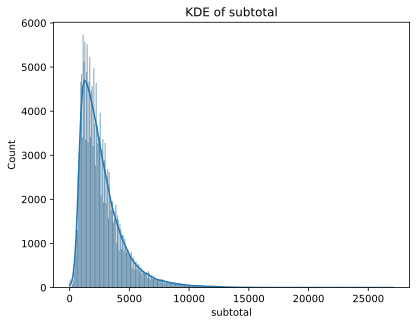

In [126]:
sns.histplot(df['subtotal'], kde=True)
plt.title('KDE of subtotal')
plt.show()

In [85]:

# sns.kdeplot(df['min_item_price'])
# plt.title('KDE of minimum item price')
# plt.show()

##### continous

In [192]:
type_df.loc[type_df['type'] == 'c']

column type  \
0                                      subtotal    c   
0                                min_item_price    c   
0                                max_item_price    c   
0                estimated_order_place_duration    c   
0  estimated_store_to_consumer_driving_duration    c   

                                                                               description_notes  
0                                          min should not be 0, compare subtotals to total items  
0                                                                   min is negative, max is high  
0  min should not be 0, max is the same as min item, check if there is only 1 item in that order  
0                                             check discription for corresponding order protocol  
0                                                                            min should not be 0

In [195]:
df['subtotal'].describe()

count    197418.000000
mean       2684.702798
std        1821.982557
min          12.000000
25%        1401.000000
50%        2200.000000
75%        3396.000000
max       27100.000000
Name: subtotal, dtype: float64

In [194]:
df.loc[df['subtotal'] == 0, 'subtotal'] = ((df['min_item_price'] + df['max_item_price'])/2) * df['total_items'].astype(float)

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



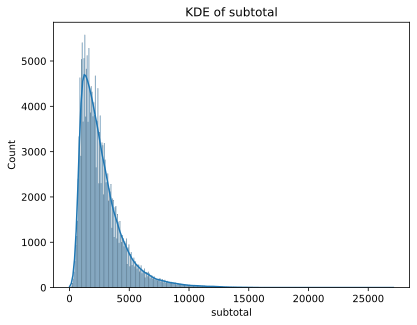

In [196]:
sns.histplot(df['subtotal'], kde=True)
plt.title('KDE of subtotal')
plt.show()

In [197]:
subtotal_bc, lmbd = boxcox(df['subtotal'])

In [198]:
df['subtotal_bc'] = subtotal_bc

In [200]:
df['subtotal_bc']

0         7.747385
1         7.208330
2         7.208330
3         8.373875
4         7.860531
            ...   
197423    6.922396
197424    7.626267
197425    7.177109
197426    6.769227
197427    7.495254
Name: subtotal_bc, Length: 197418, dtype: float64

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



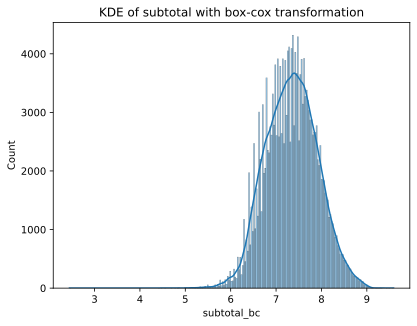

In [199]:
sns.histplot(df['subtotal_bc'], kde=True)
plt.title('KDE of subtotal with box-cox transformation')
plt.show()

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



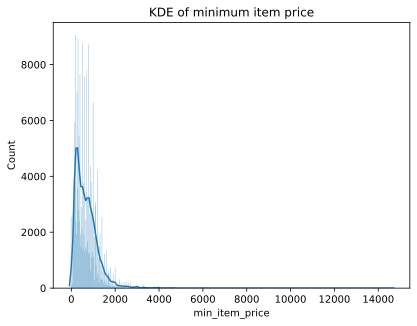

In [165]:
sns.histplot(df['min_item_price'], kde=True)
plt.title('KDE of minimum item price')
plt.show()

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



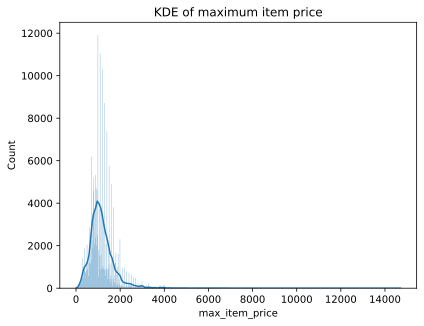

In [166]:
sns.histplot(df['max_item_price'], kde=True)
plt.title('KDE of maximum item price')
plt.show()

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



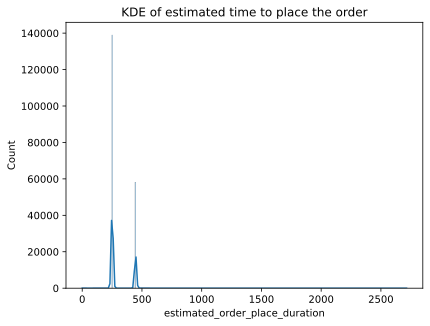

In [167]:
sns.histplot(df['estimated_order_place_duration'], kde=True)
plt.title('KDE of estimated time to place the order')
plt.show()

/Users/meganwilliams/miniconda3/envs/ddp/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



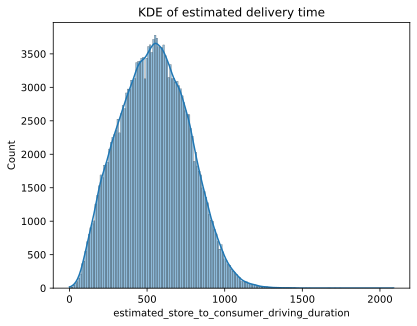

In [168]:
sns.histplot(df['estimated_store_to_consumer_driving_duration'], kde=True)
plt.title('KDE of estimated delivery time')
plt.show()

In [38]:
# converting created_at and actual_delivery_time to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [127]:
# fig = ff.create_distplot([df['subtotal']], group_labels=['subtotal in cents'], show_hist=True, show_rug=False, curve_type='kde')

# fig.show()

In [97]:
# fig = ff.create_distplot([df['min_item_price']], group_labels=['minimum items price in cents'], show_hist=True, show_rug=False, curve_type='kde')

# fig.show()

In [154]:
# fig = go.Figure(data=[go.Histogram(x=df['subtotal'], nbinsx=10000, histnorm='density')])

# kde = gaussian_kde(df['subtotal'])
# x_kde = np.linspace(df['subtotal'].min(), df['subtotal'].max(), 100000)
# kde_values = kde(x_kde)

# histogram_max = np.max(np.histogram(df['subtotal'], bins=100, density=True)[0])
# kde_scaled = kde_values * histogram_max/np.max(kde_values)

# fig.add_trace(go.Scatter(x=x_kde, y=kde_scaled, mode = 'lines', line=dict(color='red')))

# fig.show()

In [153]:
# fig = ff.create_distplot([df['max_item_price']], group_labels=['maximum in cents'], show_hist=True, show_rug=False, curve_type='kde', bin_size=10)

# fig.show()